# Analisa Porfólio de Investimentos

### Importações

In [1]:
import numpy as np
import pandas as pd
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

### Obtem dados

In [ ]:
# chave gratuita em https://www.alphavantage.co/support/#api-key
API_KEY = "0FYBJ85NIIJ88LFM"

In [3]:
def get_alpha_vantage_data(symbol):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=compact&apikey={API_KEY}"
    response = requests.get(url)
    data = response.json()

    df = pd.DataFrame.from_dict(data["Time Series (Daily)"], orient="index")
    df.index = pd.to_datetime(df.index)
    df = df.astype(float)
    return df


In [4]:
# Obtém dados do S&P 500 (usando ETF SPY)
# preços de fechamento diários do S&P 500 (via ETF SPY) e do setor de tecnologia (XLK):
sp500 = get_alpha_vantage_data("SPY")
xlk = get_alpha_vantage_data("XLK")

In [6]:
sp500.head()

,1. open,2. high,3. low,4. close,5. volume
2025-02-21,610.16,610.300,599.47,599.94,74542492.0
2025-02-20,611.54,611.684,607.02,610.38,36554002.0
2025-02-19,610.08,613.230,609.56,612.93,31011072.0
2025-02-18,610.88,611.490,608.38,611.49,26749030.0
2025-02-14,609.94,610.990,609.07,609.70,26910448.0


In [7]:
xlk.head()

,1. open,2. high,3. low,4. close,5. volume
2025-02-21,241.48,241.580,234.75,234.87,4490827.0
2025-02-20,241.95,242.270,238.86,241.41,2993874.0
2025-02-19,241.89,243.140,240.20,242.18,2802146.0
2025-02-18,241.21,242.190,240.09,242.16,3011983.0
2025-02-14,238.96,240.165,238.52,239.97,2278612.0


### Pré-Processamento

In [8]:
# últimos 100 dias
sp500 = sp500["4. close"].iloc[:100]
xlk = xlk["4. close"].iloc[:100]

# Retornos diários
df = pd.DataFrame({
    'market_return': sp500.pct_change().dropna().values,
    'sector_return': xlk.pct_change().dropna().values
})

In [9]:
df

,market_return,sector_return
0,0.017402,0.027845
1,0.004178,0.003190
2,-0.002349,-0.000083
3,-0.002927,-0.009044
4,0.000049,-0.003375
...,...,...
94,-0.009006,-0.011008
95,0.001832,-0.004129
96,-0.000422,-0.007346
97,0.009039,0.024970


### Fatores Inesperados

In [10]:
df['other_factor'] = np.random.normal(loc=0.0, scale=0.01, size=len(df))
print(df.head())

   market_return  sector_return  other_factor
0       0.017402       0.027845     -0.000129
1       0.004178       0.003190      0.002101
2      -0.002349      -0.000083     -0.003182
3      -0.002927      -0.009044      0.000466
4       0.000049      -0.003375      0.002279


### Variável de Retorno, com pesos

In [11]:
# nossa variável dependente
df['portfolio_return'] = (
    0.0005 + 0.5 * df['market_return'] + 0.3 * df['sector_return'] +
    0.1 * df['other_factor'] + np.random.normal(loc=0, scale=0.002, size=len(df))
)

In [12]:
df.shape

(99, 4)

In [13]:
df.head()

,market_return,sector_return,other_factor,portfolio_return
0,0.017402,0.027845,-0.000129,0.018554
1,0.004178,0.003190,0.002101,0.007137
2,-0.002349,-0.000083,-0.003182,-0.000710
3,-0.002927,-0.009044,0.000466,-0.003275
4,0.000049,-0.003375,0.002279,0.003127


### Treino do Modelo

In [14]:
X = df[['market_return', 'sector_return', 'other_factor']]
y = df['portfolio_return']

train_size = int(len(df) * 0.7)  # 70% para treino

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

modelo = LinearRegression()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

### Avaliação

In [15]:
y_pred = modelo.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² (coef. de determinação): {r2:.4f}\n")

RMSE: 0.0021
R² (coef. de determinação): 0.9345



In [16]:
# Coeficientes
coeficientes = modelo.coef_
fatores = X.columns

print("=== Coeficientes da Regressão ===")
for fator, coef in zip(fatores, coeficientes):
    print(f"{fator}: {coef:.4f}")

intercepto = modelo.intercept_
print(f"Intercepto (alfa): {intercepto:.4f}\n")

=== Coeficientes da Regressão ===
market_return: 0.4897
sector_return: 0.3016
other_factor: 0.1221
Intercepto (alfa): 0.0006



### Fatores mais Influêntes

In [17]:
threshold = 0.3
print("\n=== Fatores mais influentes no portfólio ===")
for fator, c in zip(fatores, coeficientes):
    if abs(c) > threshold:
        print(f"- {fator}: {c:.3f}")


=== Fatores mais influentes no portfólio ===
- market_return: 0.490
- sector_return: 0.302


### Gráficos Previsto vs Realizado

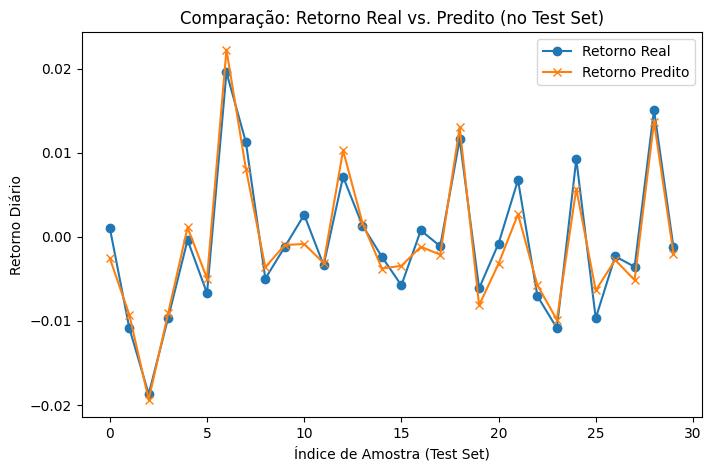

In [18]:
plt.figure(figsize=(8,5))
plt.plot(y_test.values, label='Retorno Real', marker='o')
plt.plot(y_pred, label='Retorno Predito', marker='x')
plt.title("Comparação: Retorno Real vs. Predito (no Test Set)")
plt.xlabel("Índice de Amostra (Test Set)")
plt.ylabel("Retorno Diário")
plt.legend()
plt.show()